Epoch 0, Train Loss: 0.6893, Val Loss: 0.6894, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 10, Train Loss: 0.6630, Val Loss: 0.6636, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 20, Train Loss: 0.6528, Val Loss: 0.6537, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 30, Train Loss: 0.6490, Val Loss: 0.6500, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 40, Train Loss: 0.6473, Val Loss: 0.6485, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 50, Train Loss: 0.6470, Val Loss: 0.6482, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 60, Train Loss: 0.6467, Val Loss: 0.6479, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 70, Train Loss: 0.6466, Val Loss: 0.6479, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 80, Train Loss: 0.6465, Val Loss: 0.6478, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 90, Train Loss: 0.6465, Val Loss: 0.6479, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 100, Train Loss: 0.6465, Val Loss: 0.6479, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 110, Train Loss: 0.6465, Val Loss: 0.6479, Train Acc: 0.6515, Val Acc: 0.6494
Epo

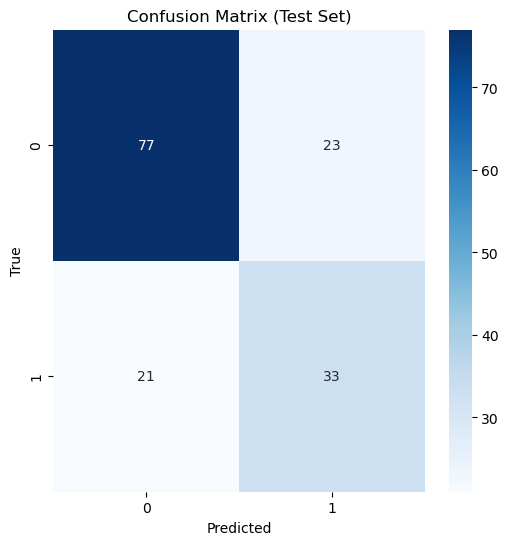

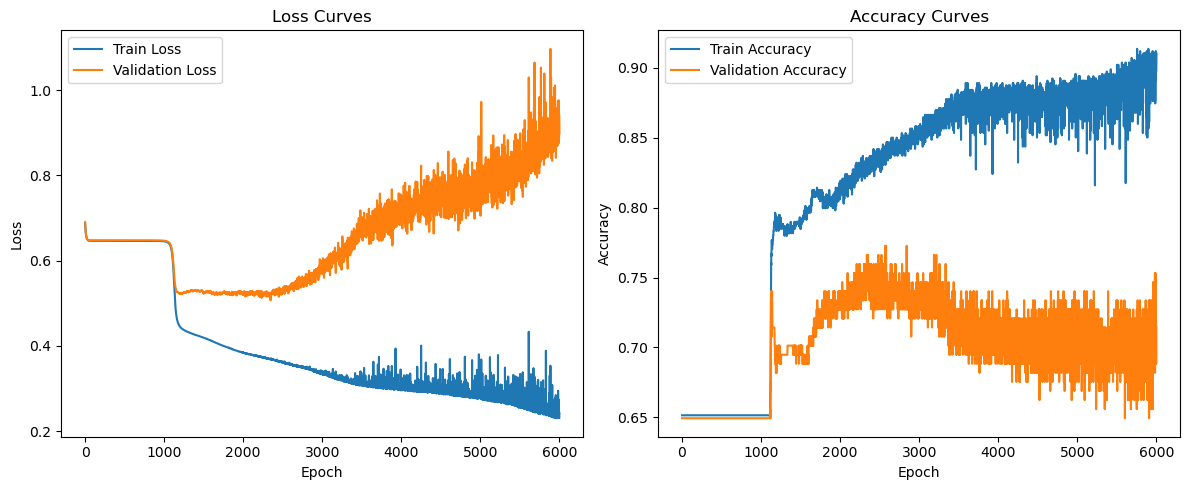

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Fonctions d’activation
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

# Classe principale du réseau de neurones
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01)
            self.biases.append(np.zeros((1, layer_sizes[i+1])))

    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        for i in range(len(self.weights) - 1):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.z_values.append(z)
            self.activations.append(relu(z))
        z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        self.z_values.append(z)
        self.activations.append(sigmoid(z))
        return self.activations[-1]

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
        return - (1/m) * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def compute_accuracy(self, y_true, y_pred):
        return np.mean((y_pred >= 0.5).astype(int) == y_true)

    def backward(self, X, y, outputs):
        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]
        dZ = outputs - y
        self.d_weights[-1] = np.dot(self.activations[-2].T, dZ) / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m
        for i in range(len(self.weights) - 2, -1, -1):
            dZ = np.dot(dZ, self.weights[i+1].T) * relu_derivative(self.z_values[i])
            self.d_weights[i] = np.dot(self.activations[i].T, dZ) / m
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m
            self.d_weights[i] += (0.01 / m) * self.weights[i]  # régularisation L2
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * self.d_weights[i]
            self.biases[i] -= self.learning_rate * self.d_biases[i]

    def train(self, X, y, X_val, y_val, epochs, batch_size, verbose=True):
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[indices[i:i+batch_size]]
                y_batch = y[indices[i:i+batch_size]]
                outputs = self.forward(X_batch)
                self.backward(X_batch, y_batch, outputs)
            train_out = self.forward(X)
            val_out = self.forward(X_val)
            train_losses.append(self.compute_loss(y, train_out))
            val_losses.append(self.compute_loss(y_val, val_out))
            train_accuracies.append(self.compute_accuracy(y, train_out))
            val_accuracies.append(self.compute_accuracy(y_val, val_out))
            if verbose and epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")
        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        return (self.forward(X) >= 0.5).astype(int)

# Prétraitement des données
def preprocess_data():
    data = pd.read_csv('diabetes.csv')
    for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
        data[col] = data[col].replace(0, data[col].median())
    X = data.drop('Outcome', axis=1).values
    y = data['Outcome'].values.reshape(-1, 1)
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Sauvegarder et charger le modèle
def save_model(model, filename="model.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump({
            'weights': model.weights,
            'biases': model.biases,
            'layer_sizes': model.layer_sizes,
            'learning_rate': model.learning_rate
        }, f)

def load_model(filename="model.pkl"):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    model = NeuralNetwork(data['layer_sizes'], data['learning_rate'])
    model.weights = data['weights']
    model.biases = data['biases']
    return model

# Évaluation avec matrice de confusion
def evaluate_model(model, X, y, title="Test"):
    y_pred = model.predict(X)
    print(f"\nClassification Report ({title}):")
    print(classification_report(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({title})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Exportation des métriques vers un fichier CSV
def export_metrics(train_losses, val_losses, train_acc, val_acc, filename="metrics.csv"):
    df = pd.DataFrame({
        "Train Loss": train_losses,
        "Validation Loss": val_losses,
        "Train Accuracy": train_acc,
        "Validation Accuracy": val_acc
    })
    df.to_csv(filename, index=False)

# Bloc principal
if __name__ == "__main__":
    X_train, X_test, y_train, y_test = preprocess_data()
    nn = NeuralNetwork([X_train.shape[1], 16, 8, 1], learning_rate=0.01)
    train_losses, val_losses, train_acc, val_acc = nn.train(X_train, y_train, X_test, y_test, epochs=6000, batch_size=32)
    evaluate_model(nn, X_test, y_test, title="Test Set")
    save_model(nn)
    export_metrics(train_losses, val_losses, train_acc, val_acc)

    # Tracer les courbes de perte et précision
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(train_acc, label='Train Accuracy')
    ax2.plot(val_acc, label='Validation Accuracy')
    ax2.set_title('Accuracy Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.savefig('loss_accuracy_curves.png')
    plt.show()
